In [37]:
import h5py
import numpy as np
import pandas as pd
import os
import re
from IPython.display import display
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [2]:
def tryint(s):
    try:
        return int(s)
    except:
        return s
     
def alphanum_key(s):
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    l.sort(key=alphanum_key)
    return l

In [13]:
class nbody_snapshot:
    def __init__(self, path):
        self.file = self.__read_snapshot__(path)
        self.TTOT = int(path.split('/')[-1].split('_')[1].split('.')[0])
        self.steps = len(self.file)
        self.current_step = 0
        self.single_star_data, self.time = self.__get_single_star_data__()
        self.center = (self.single_star_data.X1.mean(),
                       self.single_star_data.X2.mean(),
                       self.single_star_data.X3.mean())
    
    @staticmethod
    def __read_snapshot__(path):
        f = h5py.File(path)
        return f
    
    def __get_single_star_data__(self):
        rd = self.file[f'Step#{self.current_step}']
        time = list(rd.attrs.values())[0]
        keys_i = ['NAM', 'X1', 'X2', 'X3', 'V1', 'V2', 'V3', 'M', 'L', 'MC', 'RC', 'RS', 'POT', 'TE']
        de = dict()
        for key in keys_i:
            de[key] = rd[key]
        df = pd.DataFrame(data=de)
        return df, time
    
    def reload_at_step(self, step):
        if step >= len(self.file):
            raise KeyError(f'file does not have Step#{step}')
        self.current_step = step
        self.single_star_data, self.time = self.__get_single_star_data__()

    def save_single_star_data(self, filename, sep=','):
        self.single_star_data.to_csv(filename, sep=sep, index=False)
        
    def xget_steps(self, start=0, stop=None):
        if not stop:
            stop = len(self.file)
        for step in range(start, stop):
            self.reload_at_step(step)
            yield self.single_star_data, self.time
        
    def __repr__(self):
        out = list()
        last_step = (sort_nicely(list(self.file)))[-1]
        out.append(f'|---------------------------')
        out.append(f"| Snapshot     | {self.TTOT}")
        out.append(f"| N            | {len(self.single_star_data)}")
        out.append(f"| Centered at  | {self.center}")
        out.append(f"| Stat Time    | {list(self.file['Step#0'].attrs.values())[0]}")
        out.append(f"| Stop Time    | {list(self.file[last_step].attrs.values())[0]}")
        out.append(f"| Subsnaps     | {len(self.file)}")
        out.append(f'|---------------------------')
        return '\n'.join(out)
    
    def __del__(self):
        self.file.close()

In [103]:
#TODO: get the follow_ID working for xget_snaps
class snapshot_set:
    def __init__(self, basepath, subsnap=False, front_load=True):
        h5files = [x for x in os.listdir(basepath) if '.h5part' in x]
        h5files = sort_nicely(h5files)
        if front_load:
            self.snapshots = [nbody_snapshot(f"{basepath}/{x}") for x in h5files]
            self.loaded = True
        self.subsnap = subsnap
        
    def load_snaps(self, reload=False):
        if not reload and self.loaded is False:
            self.snapshots = [nbody_snapshot(f"{basepath}/{x}") for x in h5files]
            self.loaded = True

    def follow_ID(self, ID):
        assert self.loaded is True
        times = list()
        df = self.snapshots[0].single_star_data[self.snapshots[0].single_star_data['NAM'] == ID]
        if len(df) != 0:
            times.append(self.snapshots[0].TTOT)
        it = self.snapshots[(0 if self.subsnap else 1):]
        total=len(it)
        for i, snapshot in tqdm(enumerate(it), total=total):
            if not self.subsnap:
                if len(snapshot.single_star_data[snapshot.single_star_data['NAM'] == ID]) != 0:
                    tdf = snapshot.single_star_data[snapshot.single_star_data['NAM'] == ID]
                    times.append(snapshot.time)
                    df = df.append(tdf)
            else:
                for data, time in snapshot.xget_steps(start=(1 if i == 0 else 0)):
                    tdf = data[data['NAM'] == ID]
                    if len(tdf) != 0:
                        times.append(time)
                        df = df.append(tdf)
#         print(len(times))
#         print(len(df))
        df['Time'] = times
        return df.reset_index(drop=True)
    
    def dump_set(self, path, name, sep=','):
        assert self.loaded is True
        if path[-1] == '/':
            path = path[:-1]
        if not os.path.exists(path):
            os.mkdir(path)
        filenames = [f"{path}/{name}_{snap.TTOT}.csv" for snap in self.snapshots]
        for snap, filename in zip(self.snapshots, filenames):
            snap.save_single_star_data(filename, sep=sep)
            
    def __del__(self):
        if self.loaded:
            for snap in self.snapshots:
                del(snap)

# Single Snap

In [111]:
PATH = "../../../simulations/externalSimulations/oldSimulations/runTests/MultiBinaryTest/Binary0-0/Binary0-0/snap.40_0.h5part"
snap = nbody_snapshot(PATH)
del(snap)

In [89]:
for substep in snap.xget_steps(start=1):
    display(substep[0])
    break

,NAM,X1,X2,X3,V1,V2,V3,M,L,MC,RC,RS,POT,TE
0,350,0.010090,-0.538322,0.239653,1.306038,-0.007726,1.123780,5.342646e-10,0.000000,0.0,0.0,76.992622,-174.607697,7.363705e-10
1,561,0.380370,-0.213409,-0.216836,-0.814188,0.487463,0.335615,4.869148e-01,0.035292,0.0,0.0,0.446700,-6.293262,3.747043e+03
2,886,0.219749,0.350691,-0.454125,1.745318,0.797305,-0.397638,1.246325e-01,0.001788,0.0,0.0,0.160530,-4.818615,2.965630e+03
3,499,0.413445,-0.227602,-0.224521,0.686171,-1.551227,0.797802,6.456882e-01,0.090389,0.0,0.0,0.602041,-7.447367,4.083132e+03
4,471,-0.036308,0.359173,-0.044257,-0.500148,-1.533458,-0.274161,8.031906e-01,0.240840,0.0,0.0,0.731460,-7.435147,4.732762e+03
5,545,0.195058,0.308410,-0.442152,-0.460098,-1.451504,1.044649,5.269272e-01,0.043989,0.0,0.0,0.484349,-7.088306,3.802200e+03
6,638,-0.501016,-0.125923,-0.107155,-1.380154,0.462766,0.020410,3.425152e-01,0.016749,0.0,0.0,0.331473,-6.463530,3.610373e+03
7,839,-0.156994,0.430639,0.049148,-0.120574,-0.861027,1.310706,1.484724e-01,0.002811,0.0,0.0,0.185435,-6.656100,3.089491e+03
8,641,-0.433418,-0.154689,-0.569528,-0.502387,0.101084,0.362799,3.392852e-01,0.016452,0.0,0.0,0.329197,-6.528837,3.606648e+03
9,669,0.468875,0.380738,0.170542,-0.783958,0.133192,-0.328255,2.921669e-01,0.012381,0.0,0.0,0.296578,-7.111461,3.539130e+03


# Snapset no subsnap

In [72]:
PATH = "../../../simulations/externalSimulations/oldSimulations/runTests/MultiBinaryTest/Binary0-0/Binary0-0"
snapset = snapshot_set(PATH)

In [73]:
snapset.dump_set('/Users/tboudreaux/SAOSummer2018/code/General/nbodyPythonInterface/InterfaceTestData', 'TestDump')

In [74]:
NAM1 = snapset.follow_ID(1)

100%|██████████| 99/99 [00:00<00:00, 1024.25it/s]

31
31


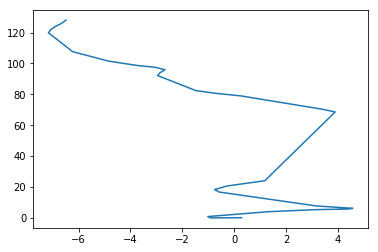

In [75]:
plt.plot(NAM1['X1'], NAM1['X2'])

# Snapset with subsnap

In [112]:
PATH = "../../../simulations/externalSimulations/oldSimulations/runTests/MultiBinaryTest/Binary0-0/Binary0-0"
snapset = snapshot_set(PATH, subsnap=True)
del(snapset)

In [105]:
NAM1 = snapset.follow_ID(1)


100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


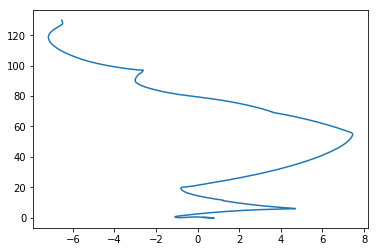

In [110]:
plt.plot(NAM1['X1'], NAM1['X2'])

In [107]:
NAM1

,NAM,X1,X2,X3,V1,V2,V3,M,L,MC,RC,RS,POT,TE,Time
0,1,0.280671,0.130485,-0.343529,1.287323,-0.608961,-0.109077,0.799761,0.235970,0.0,0.0,0.729040,-1.314914,4716.462891,0.00000
1,1,0.793361,-0.194116,-0.013425,0.142582,-0.302984,0.679931,0.799761,0.235975,0.0,0.0,0.729043,-5.454464,4716.474121,1.31250
2,1,-0.106061,0.484028,-0.229188,1.362866,0.052220,-0.137051,0.799761,0.235989,0.0,0.0,0.729053,-32.890213,4716.512695,5.81250
3,1,-0.834813,-0.102467,-0.432740,-0.725727,0.684686,-0.798479,0.799761,0.236002,0.0,0.0,0.729062,-23.850851,4716.547363,9.84375
4,1,-0.847441,-0.090345,-0.446737,-0.705465,0.689119,-0.787848,0.799761,0.236002,0.0,0.0,0.729062,-24.599035,4716.547852,9.87500
5,1,-0.859712,-0.078147,-0.460545,-0.685299,0.693276,-0.777104,0.799761,0.236002,0.0,0.0,0.729062,-24.599035,4716.547852,9.90625
6,1,-0.871628,-0.065878,-0.474162,-0.665240,0.697226,-0.766171,0.799761,0.236002,0.0,0.0,0.729062,-25.332771,4716.548340,9.93750
7,1,-0.883192,-0.053540,-0.487584,-0.645482,0.701076,-0.755040,0.799761,0.236002,0.0,0.0,0.729062,-25.332771,4716.548340,9.96875
8,1,-0.894411,-0.041134,-0.500810,-0.626190,0.705002,-0.743869,0.799761,0.236002,0.0,0.0,0.729062,-26.052963,4716.548828,10.00000
9,1,-0.908249,-0.029853,-0.514070,-0.612955,0.708025,-0.731771,0.799761,0.236002,0.0,0.0,0.729062,-0.720192,4716.548828,10.03125
